# B-tipping, R-tipping and Ritchie et al's criterion in a simple AMOC model
---
__Author__ : Couplet Victor 


__Content__ : Scripts associated to the *Chapter III - The AMOC and Stocker et al.'s paper* of the *PhD Thesis:What I've done so far* notes from Victor Couplet.

Used and modified by Amaury Laridon for his Master's Thesis.

---


In [1]:
import numpy as np

from math import floor,log10

from scipy.integrate import solve_ivp
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import linalg

%matplotlib nbagg
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc


# import numpy.math.factorial
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation


In [2]:
print(plt.rcParams)

_internal.classic_mode: False
agg.path.chunksize: 0
animation.avconv_args: []
animation.avconv_path: avconv
animation.bitrate: -1
animation.codec: h264
animation.convert_args: []
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.html_args: []
animation.writer: ffmpeg
axes.autolimit_mode: data
axes.axisbelow: line
axes.edgecolor: black
axes.facecolor: white
axes.formatter.limits: [-5, 6]
axes.formatter.min_exponent: 0
axes.formatter.offset_threshold: 4
axes.formatter.use_locale: False
axes.formatter.use_mathtext: False
axes.formatter.useoffset: True
axes.grid: False
axes.grid.axis: both
axes.grid.which: major
axes.labelcolor: black
axes.labelpad: 4.0
axes.labelsize: medium
axes.labelweight: normal
axes.linewidth: 0.8
axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
axes

# Temperature equation 

\begin{equation}
      \frac{d\Delta T}{dt} = \left(\lambda \Delta T + 5.35\ln\left(\frac{C}{280}\right)\right)\frac{h}{c}
\end{equation}


# Prescribed $CO_2$ concentrations scenarios

## Geometric ramping increase

\begin{equation}
    C(t) = 
\begin{cases}
280(1+r)^t & \text{if $t< t_{max}$}\\
280(1+r)^{t_{max}} &\text{if $t\geq t_{max}$}
\end{cases}
\end{equation}
with $t_{max}=\frac{\ln(C_{max}/280)}{\ln(1+r)}$ such that $C(t=t_{max})=C_{max}$.

In [2]:
def ramping1(r,cmax,t0,tend,dt):
    
    n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)
    p=np.ones(teval.shape)*cmax
    q=np.log(cmax/280)/np.log(1+r)
    p[teval<q] = 280*(1+r)**teval[teval<q]
    
    P=interpolate.interp1d(teval,p,fill_value="extrapolate")
    
    return P

## Geometric ramping increase then decrease

\begin{equation}
    C(t) = 
\begin{cases}
280(1+r)^t & \text{if $t< t_{max}$}\\
C_{max}(1-r)^{t-t_{max}} &\text{if $t_{max} \leq t< 2 t_{max}$}\\
280  & \text{if $t\geq  2 t_{max}$}
\end{cases}
\end{equation}
with $t_{max}=\frac{\ln(C_{max}/280)}{\ln(1+r)}$ such that $C(t=t_{max})=C_{max}$.


In [3]:
def ramping2(r,cmax,t0,tend,dt):
    
    n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)
    p=np.ones(teval.shape)*cmax
    q=np.log(cmax/280)/np.log(1+r)
    p[teval<q] = 280*(1+r)**teval[teval<q]
    p[teval>q] = cmax*(1-r)**(teval[teval>q]-q)
    p[teval>2*q] = 280
    
    P=interpolate.interp1d(teval,p,fill_value="extrapolate")
    
    return P

## RCP scenarios

RCP scenarios from IPPC

<IPython.core.display.Javascript object>


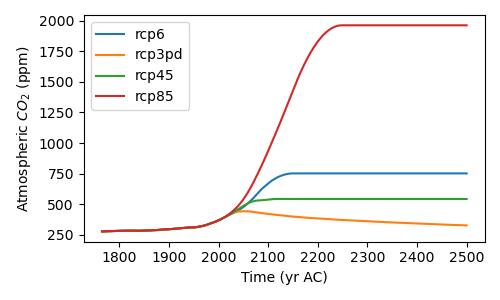

In [4]:

# matplotlib.rcParams['figure.facecolor'] = 'white'
# matplotlib.rcParams['axes.facecolor'] = 'white'

# plt.style.use('dark_background')

# matplotlib.rcParams['figure.facecolor'] ='#272B34'
# matplotlib.rcParams['axes.facecolor'] = '#272B34'


rcp6=np.loadtxt(r"/home/vcouplet/Desktop/THESE/Data/rcp6.DAT")
rcp3pd=np.loadtxt(r"/home/vcouplet/Desktop/THESE/Data/rcp3pd.DAT")
rcp45=np.loadtxt(r"/home/vcouplet/Desktop/THESE/Data/rcp45.DAT")
rcp85=np.loadtxt(r"/home/vcouplet/Desktop/THESE/Data/rcp85.DAT")

fig,ax=plt.subplots(figsize=(5,3))

ax.plot(rcp6[:,0],rcp6[:,3],label='rcp6')
ax.plot(rcp6[:,0],rcp3pd[:,3],label='rcp3pd')
ax.plot(rcp6[:,0],rcp45[:,3],label='rcp45')
ax.plot(rcp6[:,0],rcp85[:,3],label='rcp85')
ax.set_xlabel(r'Time (yr AC)')
ax.set_ylabel(r'Atmospheric $CO_2$ (ppm)')
ax.legend()

plt.tight_layout()

In [5]:
RCP3=interpolate.interp1d(rcp3pd[:,0],rcp3pd[:,3],fill_value="extrapolate")
RCP45=interpolate.interp1d(rcp45[:,0],rcp45[:,3],fill_value="extrapolate")
RCP6=interpolate.interp1d(rcp6[:,0],rcp6[:,3],fill_value="extrapolate")
RCP85=interpolate.interp1d(rcp85[:,0],rcp85[:,3],fill_value="extrapolate")

# Models in one dimension

## Model 1.1 : rate involved in B-tipping

\begin{equation}
    \frac{dy}{dt}= \left(y-y^3 - \sqrt{\frac{4}{27}}\frac{q(\Delta T , \dot{\Delta T})}{q_{crit}}\right)\frac{1}{\tau}
\end{equation}

$$q(\Delta T , \dot{\Delta T})= \Delta T +\alpha \dot{\Delta T} $$



In [15]:
h=365*24*3600

def amocmodel11(forcing,c,lam,qcrit,alpha,tau,t0,tend,dt,y0):
    
    n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)
   
    def f(t,y):
    
        F=forcing(t)
        z=float(np.log(F/280))
        
        dy = [0,0]
        
        dy[0] = (lam*y[0]+ 5.35*z)*h/c
        dy[1] = (y[1]-y[1]**3-(4/27)**0.5/qcrit*(y[0]+alpha*(lam*y[0]+ 5.35*z)*h/c))/tau
        
        return dy
    
    sol=solve_ivp(f, [t0,tend], y0,method= 'LSODA',max_step=10,t_eval=teval)
    #sol=solve_ivp(f, [t0,tend], y0,method= 'RK45',t_eval=teval)
    
    return sol ;


### Reproductions of Stocker & Schmitter's results

<IPython.core.display.Javascript object>


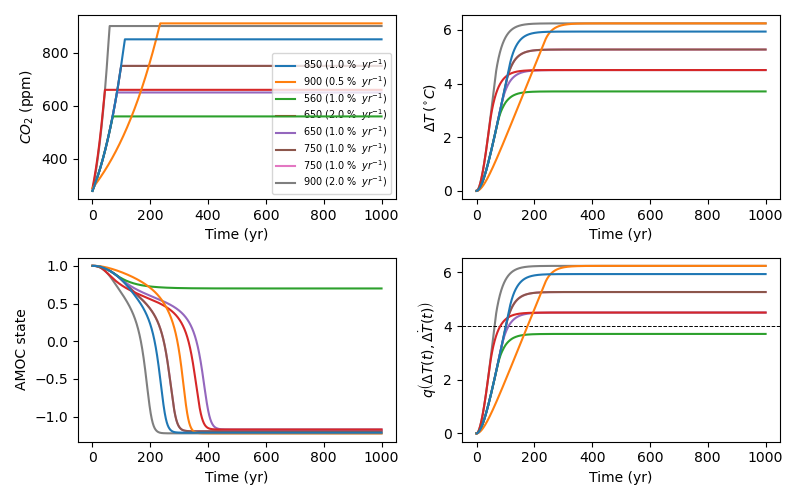

850 1.0  :  0.04531203872934235
900 0.5  :  3.8004043538302836


In [67]:
c=8.36*10**8
lam=-1
qcrit = 4
alpha=0
tau = 30

t0=0; tend=1000 
dt=0.01
y0=[0,1]

cmax=[850,900, 560,650,650,750,750,900]
r=np.array([1,0.5,1,2,1,1,1,2])*0.01
dec=[0,10,0,10,0,0,0,0]

M=lam*h/c 
db = 1/tau**2*8/3*(1/qcrit)


fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=(8,5))

for i in range (0,r.size):
    
    forcing = ramping1(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel11(forcing,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
    
    ax1.plot(sol.t,forcing(sol.t)+dec[i],label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100),zorder=r.size-i)
    ax2.plot(sol.t,sol.y[0],zorder=r.size-i)
    ax3.plot(sol.t,sol.y[1],zorder=r.size-i)
    ax4.plot(sol.t, sol.y[0]+alpha*(lam*sol.y[0]+ 5.35*np.log(forcing(sol.t)/280))*h/c,zorder=r.size-i)
    
    B = 5.35*h/c*np.log(1+r[i])
    tmax = np.log(cmax[i]/280)/np.log(1+r[i])
    maxy = (B/M**2+alpha*B/M)*(np.exp(M*tmax)-1)-B/M*tmax
        
    if  maxy> qcrit :
        
            R =  maxy-qcrit
            
            z = sol.y[0]+alpha*(lam*sol.y[0]+ 5.35*np.log(forcing(sol.t)/280))*h/c
            
            ki = np.argmin(np.abs(z[sol.t<tmax]-qcrit))
            ti = sol.t[ki]
            
            kf = np.argmin(np.abs(z[sol.t>tmax]-qcrit))
            tf = sol.t[sol.t>tmax][kf]
            ritchie = db*R*(tf-ti)**2
            print(cmax[i],r[i]*100,' : ',ritchie)
            

ax1.set_xlabel(r'Time (yr)')
ax1.set_ylabel(r'$CO_2$ (ppm)')
ax1.legend(fontsize=7,labelspacing=0.1)

ax2.set_xlabel(r'Time (yr)')
ax2.set_ylabel(r'$\Delta T\:(^{\circ}C)$')

ax3.set_xlabel(r'Time (yr)')
ax3.set_ylabel(r'AMOC state')

ax4.set_xlabel(r'Time (yr)')
ax4.set_ylabel(r'$q\left(\Delta T(t),\dot{\Delta T}(t)\right)$')
ax4.axhline(qcrit,0,1,c='k',ls='--',lw=0.7)


plt.tight_layout()

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\stockgid1.pdf")

<IPython.core.display.Javascript object>


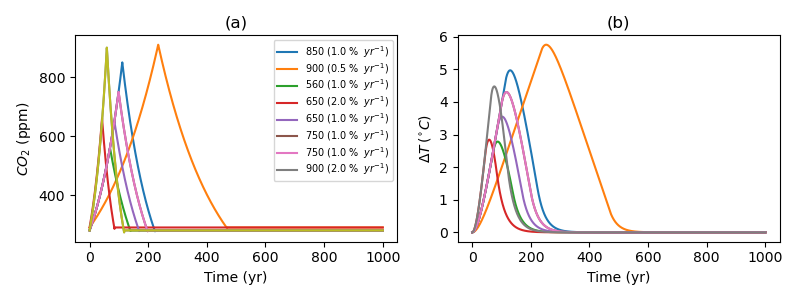

In [68]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))

for i in range (0,r.size):
    
    forcing = ramping2(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel11(forcing,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
    
    ax1.plot(sol.t,forcing(sol.t)+dec[i],label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100))
    ax2.plot(sol.t,sol.y[0])
    
ax1.set_xlabel(r'Time (yr)')
ax1.set_ylabel(r'$CO_2$ (ppm)')
ax1.legend(fontsize=7,labelspacing=0.1)
ax1.set_title('(a)')

ax2.set_xlabel(r'Time (yr)')
ax2.set_ylabel(r'$\Delta T\:(^{\circ}C)$')
ax2.set_title('(b)')

plt.tight_layout()

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\stock1.pdf")

<IPython.core.display.Javascript object>


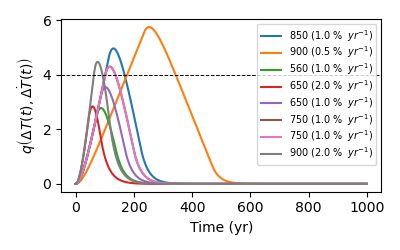

In [69]:
fig, (ax4) = plt.subplots(1,1,figsize=(4,2.5))

for i in range (0,r.size):
    
    forcing = ramping2(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel11(forcing,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
    
#     ax3.plot(sol.t,sol.y[1],label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100))
    ax4.plot(sol.t, sol.y[0]+alpha*(lam*sol.y[0]+ 5.35*np.log(forcing(sol.t)/280))*h/c,label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100))

ax1.plot(sol.t,forcing(sol.t)+dec[i])

# ax3.set_xlabel(r'Time (yr)')
# ax3.set_ylabel(r'AMOC state')
# ax3.legend(fontsize=7,labelspacing=0.1)

ax4.set_xlabel(r'Time (yr)')
ax4.set_ylabel(r'$q\left(\Delta T(t),\dot{\Delta T}(t)\right)$')
ax4.axhline(qcrit,0,1,c='k',ls='--',lw=0.7)
ax4.legend(fontsize=7,labelspacing=0.1)


plt.tight_layout()

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\stock4.pdf")

<IPython.core.display.Javascript object>


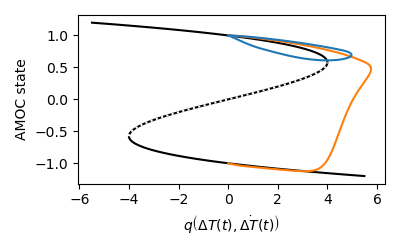

In [70]:
fig, (ax1) = plt.subplots(1,1,figsize=(4,2.5))


v=np.linspace(-1.2,1.2,100)
vv = np.linspace(-1/3**0.5,1/3**0.5,60)

ax1.plot((v-v**3)*(27/4)**0.5*qcrit,v,'k',zorder=0)
ax1.plot((vv-vv**3)*(27/4)**0.5*qcrit,vv,'w:',zorder=0)

for i in range (0,2):
    
    forcing = ramping2(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel11(forcing,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
    
    ax1.plot(sol.y[0]+alpha*(lam*sol.y[0]+ 5.35*np.log(forcing(sol.t)/280))*h/c,sol.y[1],label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100),zorder=r.size-i)
   
        
ax1.set_ylabel(r'AMOC state')
ax1.set_xlabel(r'$q\left(\Delta T(t),\dot{\Delta T}(t)\right)$')
# ax1.legend(fontsize=7,labelspacing=0.02,framealpha=1)
# ax1.set_ylim((0.25,1.15))
# ax1.set_xlim((-0.25,11))


plt.tight_layout()

# fig.savefig(r"/home/vcouplet/Desktop/bifur.svg")

In [ ]:
fig, (ax2,ax1) = plt.subplots(1,2,figsize=(8,3))

cmax=[850,850, 560,650,650,750,750,900]
r=np.array([1,0.3,1,2,1,1,1,2])*0.01

v=np.linspace(-1.2,1.2,100)
vv = np.linspace(-1/3**0.5,1/3**0.5,60)

ax1.plot(-(v-v**3)*(27/4)**0.5*qcrit,v,'k',zorder=0)
ax1.plot(-(vv-vv**3)*(27/4)**0.5*qcrit,vv,'w:',zorder=0)

for i in range (0,2):
    
    forcing = ramping2(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel11(forcing,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
    
    ax1.plot(sol.y[0]+alpha*(lam*sol.y[0]+ 5.35*np.log(forcing(sol.t)/280))*h/c,sol.y[1],label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100),zorder=r.size-i)
    ax2.plot(sol.t,sol.y[0],zorder=r.size-i)
    

# ax1.legend(fontsize=7,labelspacing=0.02,framealpha=1)
# ax1.set_ylim((0.25,1.15))
# ax1.set_xlim((-0.25,11))

ax2.axhline(4,0,1,color='k',ls='--')
ax2.set_ylim((-0.3,7))
ax2.annotate(r'$\Delta T_{crit}$', (600,4.2))
ax2.set_xlabel(r'Time (yr)')
ax2.set_ylabel(r'$\Delta T\:(^{\circ}C)$')


ax1.set_xlabel(r'Control parameter $\Delta T\:(^{\circ}C)$ ')
ax1.set_ylabel(r'State of tipping element')

plt.tight_layout()

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\youngminds3.svg",transparent=True)

<IPython.core.display.Javascript object>


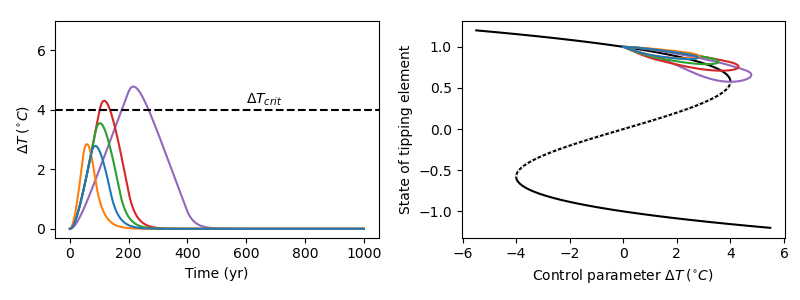

In [73]:
fig, (ax2,ax1) = plt.subplots(1,2,figsize=(8,3))

cmax=[560,650,650,750,750]
r=np.array([1,2,1,1,0.5])*0.01

v=np.linspace(-1.2,1.2,100)
vv = np.linspace(-1/3**0.5,1/3**0.5,60)

ax1.plot((v-v**3)*(27/4)**0.5*qcrit,v,'k',zorder=0)
ax1.plot((vv-vv**3)*(27/4)**0.5*qcrit,vv,'w:',zorder=0)

for i in range (0,5):
    
    forcing = ramping2(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel11(forcing,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
    
    ax1.plot(sol.y[0]+alpha*(lam*sol.y[0]+ 5.35*np.log(forcing(sol.t)/280))*h/c,sol.y[1],label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100),zorder=r.size-i)
    ax2.plot(sol.t,sol.y[0],zorder=r.size-i)
    

# ax1.legend(fontsize=7,labelspacing=0.02,framealpha=1)
# ax1.set_ylim((0.25,1.15))
# ax1.set_xlim((-0.25,11))

ax2.axhline(4,0,1,color='k',ls='--')
ax2.set_ylim((-0.3,7))
ax2.annotate(r'$\Delta T_{crit}$', (600,4.2))
ax2.set_xlabel(r'Time (yr)')
ax2.set_ylabel(r'$\Delta T\:(^{\circ}C)$')


ax1.set_xlabel(r'Control parameter $\Delta T\:(^{\circ}C)$ ')
ax1.set_ylabel(r'State of tipping element')

plt.tight_layout()

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\youngminds3.svg",transparent=True)

<IPython.core.display.Javascript object>


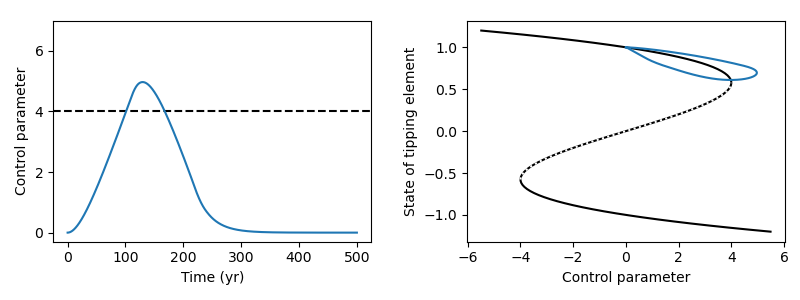

In [15]:
fig, (ax2,ax1) = plt.subplots(1,2,figsize=(8,3))
tend=500

v=np.linspace(-1.2,1.2,100)
vv = np.linspace(-1/3**0.5,1/3**0.5,60)

ax1.plot((v-v**3)*(27/4)**0.5*qcrit,v,'k',zorder=0)
ax1.plot((vv-vv**3)*(27/4)**0.5*qcrit,vv,'w:',zorder=0)

for i in range (0,1):
    
    forcing = ramping2(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel11(forcing,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
    
    ax1.plot(sol.y[0]+alpha*(lam*sol.y[0]+ 5.35*np.log(forcing(sol.t)/280))*h/c,sol.y[1],label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100),zorder=r.size-i)
    ax2.plot(sol.t,sol.y[0],zorder=r.size-i)
    

# ax1.legend(fontsize=7,labelspacing=0.02,framealpha=1)
# ax1.set_ylim((0.25,1.15))
# ax1.set_xlim((-0.25,11))

ax2.axhline(4,0,1,color='k',ls='--')
ax2.set_ylim((-0.3,7))
# ax2.annotate(r'$\Delta T_{crit}$', (600,4.2))
ax2.set_xlabel(r'Time (yr)')
ax2.set_ylabel(r'Control parameter')


ax1.set_xlabel(r'Control parameter')
ax1.set_ylabel(r'State of tipping element')

plt.tight_layout()
plt.subplots_adjust(wspace = 0.3)

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\potsdamritchie.svg",transparent=True)

In [16]:
c=8.36*10**8
qcrit = 6.5
alpha=150
tau = 30

y0=[0,1]
t0=0; tend=1500 
dt=1

N=10
lam = np.linspace(-1.86,-0.93,N)
r = np.linspace(0.2,2,N)*0.01

Ccrit = np.zeros((N,N))

for i in range(0,N) :
 
    for j in range(0,N) :
        
        c1=200
        c2=2300
        cmax=(c1+c2)/2
        
        forcing = ramping1(r[j],cmax,t0,tend,dt)
        sol = amocmodel11(forcing,c,lam[i],qcrit,alpha,tau,t0,tend,dt,y0)
        b=sol.y[1][-1]
        
        for k in range(0,10) :
        
            if b>0 :
                c1=cmax
                cmax=(c1+c2)/2 
            else : 
                c2=cmax
                cmax=(c1+c2)/2
                
            forcing = ramping1(r[j],cmax,t0,tend,dt)
            sol = amocmodel11(forcing,c,lam[i],qcrit,alpha,tau,t0,tend,dt,y0)
            b = sol.y[1][-1]
            
            
     
        Ccrit[i,j]=cmax
        
        
    print(i)
            

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


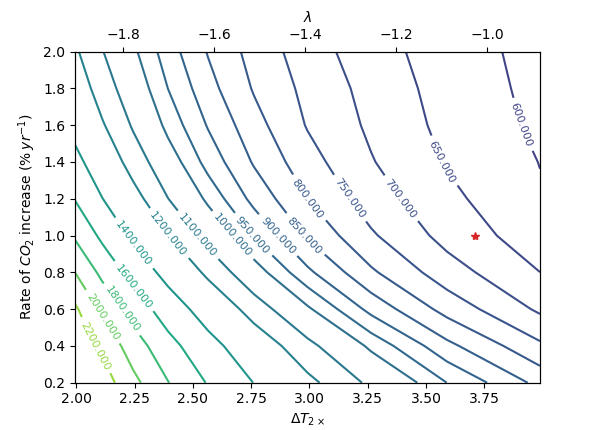

Text(0.5, 0, '$\\lambda$')

In [17]:
lam = np.linspace(-1.86,-0.93,N)
r = np.linspace(0.2,2,N)*0.01

L,R = np.meshgrid(lam,r)
fig, (ax1) = plt.subplots(1,1,figsize=(6,4.3))

lines = [600,650,700,750,800,850,900,950,1000,1100,1200,1400,1600,1800,2000,2200]

CS = ax1.contour(-3.71/lam,r*100,Ccrit.transpose(),lines,cmap='viridis',vmin=100,vmax=2600) 
ax1.clabel(CS, inline=2, fontsize=8)
ax1.plot(3.71,0.01*100,'C3*')
ax1.set_ylim((0.2,2))
ax1.set_ylabel(r'Rate of $CO_2$ increase ($\%\:yr^{-1}$)')
ax1.set_xlabel(r'$\Delta T_{2\times}$')

ax2 =ax1.twiny()
ax2.plot(lam,np.ones(lam.size)*2, color='None')
ax2.set_xlabel(r'$\lambda$')

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\stock3.pdf")

In [39]:
%%time

c=8.36*10**8
lam=-1
qcrit = 6.5
alpha=150
tau = 30

y0=[0,1]
t0=0; tend=2500 
dt=1

N=20

r = np.linspace(0.2,2,N)*0.01
cmax=np.linspace(400,1100,N)
tip = np.zeros((N,N))
maxy = np.zeros((N,N))
ritchie = np.zeros((N,N))

M=lam*h/c 
db = 1/tau**2*8/3*(1/qcrit)

for i in range(0,N) :
    print(i)
    for j in range(0,N) :

        forcing = ramping1(r[i],cmax[j],t0,tend,dt)
        sol = amocmodel11(forcing,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
        
        tip[i,j]=sol.y[1][-1]
        B = 5.35*h/c*np.log(1+r[i])
        tmax= np.log(cmax[j]/280)/np.log(1+r[i])
        maxy[i,j] = (B/M**2+alpha*B/M)*(np.exp(M*tmax)-1)-B/M*tmax
        
        if  maxy[i,j]> qcrit :
        
            R =  maxy[i,j]-qcrit
#             tf = 1/M*np.log((qcrit+B*tmax/M)/((B/M**2+alpha*B/M)*(1-np.exp(-M*tmax))))
            z = sol.y[0]+alpha*(lam*sol.y[0]+ 5.35*np.log(forcing(sol.t)/280))*h/c
            
            ki = np.argmin(np.abs(z[sol.t<tmax]-qcrit))
            ti = sol.t[ki]
            
            kf = np.argmin(np.abs(z[sol.t>tmax]-qcrit))
            tf = sol.t[sol.t>tmax][kf]
            
            ritchie[i,j] = db*R*(tf-ti)**2

            
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 14.6 s, sys: 20 ms, total: 14.6 s
Wall time: 14.6 s


<IPython.core.display.Javascript object>


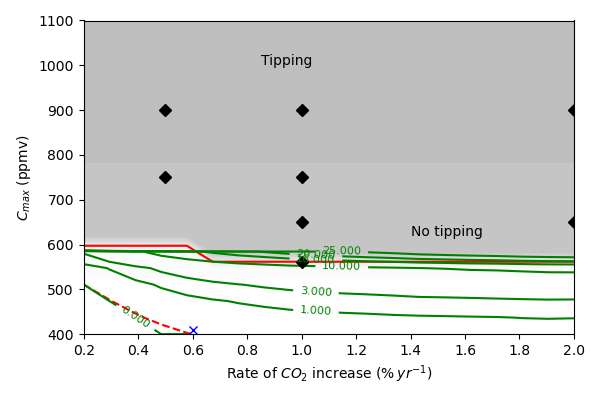

In [38]:
N=20

r = np.linspace(0.2,2,N)*0.01
cmax=np.linspace(400,1100,N)

fig, (ax1) = plt.subplots(1,1,figsize=(6,4))

cs=ax1.contourf(r*100,cmax,-tip.transpose(),20,cmap='Greys',vmax=5) 
cs2 =ax1.contour(r*100,cmax,maxy.transpose()-qcrit,0,colors='r',linestyles='--')
cs3 =ax1.contour(r*100,cmax,-tip.transpose(),0,colors='r',linestyles='-')
cs4 =ax1.contour(r*100,cmax,ritchie.transpose(),[0.0,1,3,10,16,20,25],colors='g',linestyles='-')
ax1.clabel(cs4, inline=1, fontsize=8)

# ax1.plot(r*100,np.ones(r.size)*280*np.exp(-lam*qcrit/5.35),c='r',ls='--')
ax1.plot(np.array([1,2,1,1,0.5,0.5,1,2]),[560,650,650,750,750,900,900,900],'kD')
ax1.set_xlabel(r'Rate of $CO_2$ increase ($\%\:yr^{-1}$)')
ax1.set_ylabel(r'$C_{max}$ (ppmv)')
ax1.plot([0.6],[410],'bx')

# ax1.annotate(r'Rate involved in B-tipping', (1.2,800))
# ax1.annotate(r'(no tipping if $\alpha=0$)', (1.285,760))
# ax1.annotate(r'B-tipping even if $\alpha=0$', (0.6,1000))
ax1.annotate(r'No tipping', (1.4,620))
ax1.annotate(r'Tipping', (0.85,1000))

plt.tight_layout()

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\stockgid2.pdf")

### RCP scenarios

In [101]:
c=8.36*10**8
lam=-1
qcrit = 6.5
alpha=150
tau = 30

y0=[0,1]
t0=1800; tend=2500 
dt=0.01

sol3 = amocmodel11(RCP3,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
sol45 = amocmodel11(RCP45,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
sol6 = amocmodel11(RCP6,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
sol85 = amocmodel11(RCP85,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)

<IPython.core.display.Javascript object>


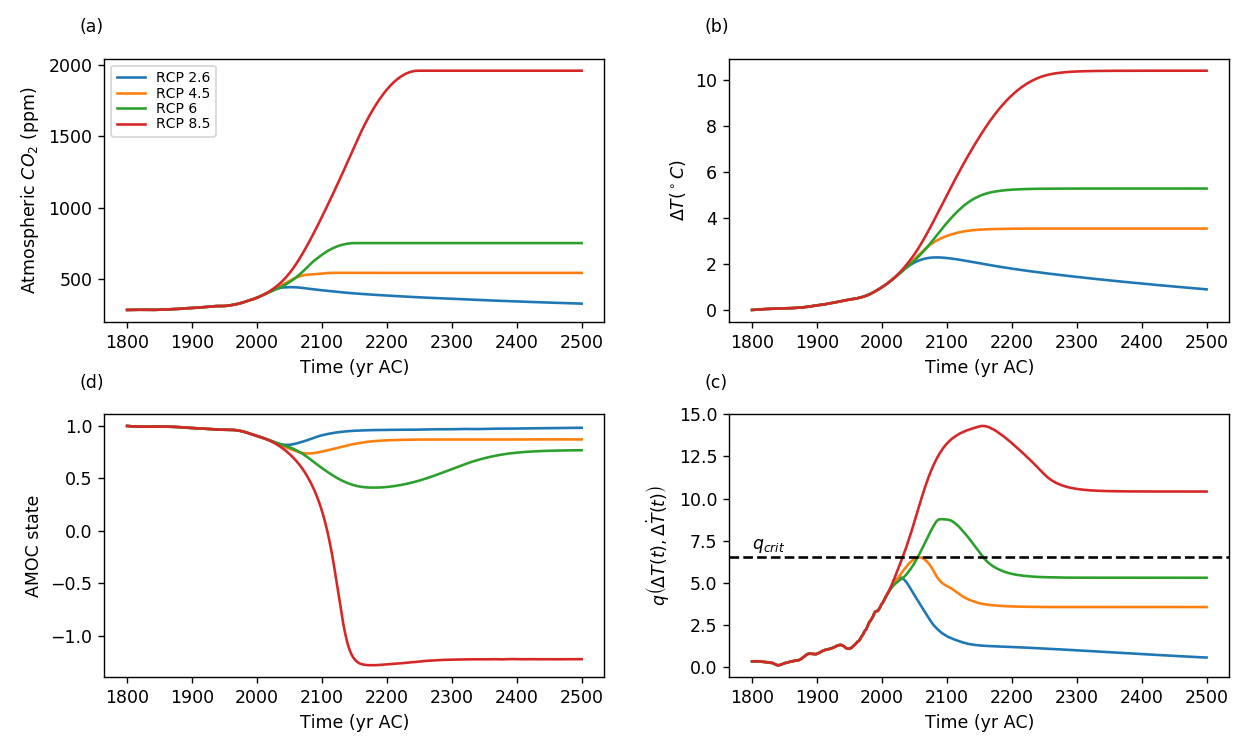

C:\Users\vicco\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Users\vicco\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


In [105]:
fig, ([ax3,ax1],[ax2,ax4]) = plt.subplots(2,2,figsize=(10,6))

ax1.plot(sol3.t,sol3.y[0],label='RCP 2.6')
ax2.plot(sol3.t,sol3.y[1],label='RCP 2.6')
ax3.plot(sol3.t,RCP3(sol3.t),label='RCP 2.6')
ax4.plot(sol3.t, sol3.y[0]+alpha*(lam*sol3.y[0]+ 5.35*np.log(RCP3(sol3.t)/280))*h/c,label='RCP 2.6')

ax1.plot(sol45.t,sol45.y[0],label='RCP 4.5')
ax2.plot(sol45.t,sol45.y[1],label='RCP 4.5')
ax3.plot(sol45.t,RCP45(sol45.t),label='RCP 4.5')
ax4.plot(sol45.t, sol45.y[0]+alpha*(lam*sol45.y[0]+ 5.35*np.log(RCP45(sol45.t)/280))*h/c,label='RCP 4.5')

ax1.plot(sol6.t,sol6.y[0],label='RCP 6')
ax2.plot(sol6.t,sol6.y[1],label='RCP 6')
ax3.plot(sol6.t,RCP6(sol6.t),label='RCP 6')
ax4.plot(sol6.t, sol6.y[0]+alpha*(lam*sol6.y[0]+ 5.35*np.log(RCP6(sol6.t)/280))*h/c,label='RCP6')

ax1.plot(sol85.t,sol85.y[0],label='RCP 8.5')
ax2.plot(sol85.t,sol85.y[1],label='RCP 8.5')
ax3.plot(sol85.t,RCP85(sol85.t),label='RCP 8.5')
ax4.plot(sol85.t, sol85.y[0]+alpha*(lam*sol85.y[0]+ 5.35*np.log(RCP85(sol85.t)/280))*h/c,label='RCP 8.5')

ax4.axhline(qcrit,0,1,c='k',ls='--')

ax1.set_xlabel(r'Time (yr AC)')
ax3.set_ylabel(r'Atmospheric $CO_2$ (ppm)')

ax2.set_xlabel(r'Time (yr AC)')
ax1.set_ylabel(r'$\Delta T (^\circ C)$')

ax3.set_xlabel(r'Time (yr AC)')
ax4.set_ylabel(r'$q\left(\Delta T(t),\dot{\Delta T}(t)\right)$')

ax4.set_xlabel(r'Time (yr AC)')
ax2.set_ylabel(r'AMOC state')

ax4.annotate(r'$q_{crit}$',(1800,7))

# ax1.legend(fontsize=8,labelspacing=0.1)
# ax2.legend(fontsize=8,labelspacing=0.1)
ax3.legend(fontsize=8,labelspacing=0.1)
# ax4.legend(fontsize=8,labelspacing=0.1)

ax2.text(-0.05, 1.1,'(d)', transform=ax2.transAxes,fontsize=10)
ax3.text(-0.05, 1.1,'(a)', transform=ax3.transAxes,fontsize=10)
ax1.text(-0.05, 1.1,'(b)', transform=ax1.transAxes,fontsize=10)
ax4.text(-0.05, 1.1,'(c)', transform=ax4.transAxes,fontsize=10)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.25)
plt.subplots_adjust(hspace = 0.35)

fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\stockrcp.pdf")

# Maybe a should of have used a loop haha

<IPython.core.display.Javascript object>


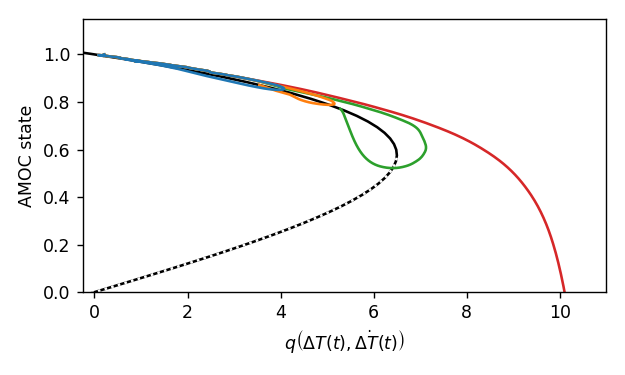

In [50]:
fig, (ax1) = plt.subplots(1,1,figsize=(5,3))


v=np.linspace(-1.3,1.05,100)
vv = np.linspace(-1/3**0.5,1/3**0.5,60)

ax1.plot((v-v**3)*(27/4)**0.5*qcrit,v,'k',zorder=0)
ax1.plot((vv-vv**3)*(27/4)**0.5*qcrit,vv,'w:',zorder=0)


ax1.plot(sol3.y[0]+alpha*(lam*sol3.y[0]+ 5.35*np.log(RCP3(sol3.t)/280))*h/c,sol3.y[1],label=r'RCP3PD',zorder=4)
ax1.plot(sol45.y[0]+alpha*(lam*sol45.y[0]+ 5.35*np.log(RCP45(sol45.t)/280))*h/c,sol45.y[1],label=r'RCP45',zorder=3)
ax1.plot(sol6.y[0]+alpha*(lam*sol6.y[0]+ 5.35*np.log(RCP6(sol6.t)/280))*h/c,sol6.y[1],label=r'RCP6',zorder=2)
ax1.plot(sol85.y[0]+alpha*(lam*sol85.y[0]+ 5.35*np.log(RCP85(sol85.t)/280))*h/c,sol85.y[1],label=r'RCP85',zorder=1)

ax1.set_ylabel(r'AMOC state')
ax1.set_xlabel(r'$q\left(\Delta T(t),\dot{\Delta T}(t)\right)$')
# ax1.legend(fontsize=8,labelspacing=0.02,framealpha=1,loc='upper left')
ax1.set_ylim((0.0,1.15))
ax1.set_xlim((-0.25,11))
plt.tight_layout()

# fig.savefig('ts_figrcp2zoom.pdf')    

## Model 1.2 : "Naive" B-tipping + R-tipping

In [18]:
c=8.36*10**8
lam=-1
qcrit = 6.5
alpha=150
tau = 30

t0=0; tend=1000 
dt=0.01
y0=[0,1]

cmax=[560,650,650,750,750]
r=np.array([1,2,1,1,0.5])*0.01
dec=[0,10,0,10,0]


fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=(8,5))

for i in range (0,r.size):
    
    forcing = ramping1(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel_12(forcing,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
    
    ax1.plot(sol.t,forcing(sol.t)+dec[i],label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100))
    ax2.plot(sol.t,sol.y[0])
    ax3.plot(sol.t,sol.y[1])
    ax4.plot(sol.t, sol.y[0]+alpha*(lam*sol.y[0]+ 5.35*np.log(forcing(sol.t)/280))*h/c)


ax1.set_xlabel(r'Time (yr)')
ax1.set_ylabel(r'$CO_2$ (ppm)')
ax1.legend(fontsize=7,labelspacing=0.1)

ax2.set_xlabel(r'Time (yr)')
ax2.set_ylabel(r'$\Delta T\:(^{\circ}C)$')

ax3.set_xlabel(r'Time (yr)')
ax3.set_ylabel(r'AMOC state')

ax4.set_xlabel(r'Time (yr)')
ax4.set_ylabel(r'$\Delta T(t)+\alpha\dot{\Delta T}(t)$')
ax4.axhline(qcrit,0,1,c='k',ls='--',lw=0.7)


plt.tight_layout()

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\stockrtip.pdf")

<IPython.core.display.Javascript object>

NameError: name 'amocmodel_12' is not defined

<IPython.core.display.Javascript object>


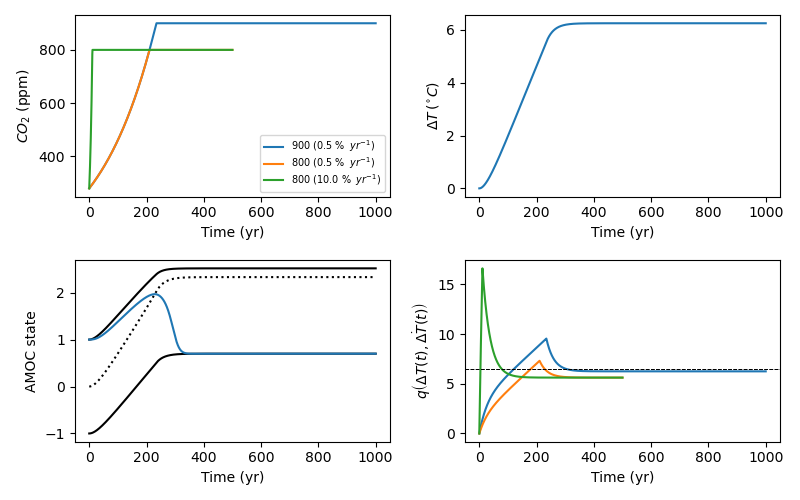

In [13]:
from numpy.polynomial import Polynomial as P

c=8.36*10**8
lam=-1
qcrit = 6.5
alpha=150
tau = 30

t0=0; tend=1000 
dt=0.1
y0=[0,1]

cmax=[900]
r=np.array([0.5])*0.01
dec = [0]


fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=(8,5))

for i in range (0,r.size):
    
    forcing = ramping1(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel_12(forcing,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
    
    ax1.plot(sol.t,forcing(sol.t)+dec[i],label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100))
    ax2.plot(sol.t,sol.y[0])
    
    ax4.plot(sol.t, sol.y[0]+alpha*(lam*sol.y[0]+ 5.35*np.log(forcing(sol.t)/280))*h/c)
#     ax4.plot(sol.y[0]+alpha*(lam*sol.y[0]+ 5.35*np.log(forcing(sol.t)/280))*h/c)
    
    N=sol.y[0].size
    Z=np.empty((3,N))
    Z[:]=np.NaN

    for k in range (0,N) :
        
#         When using amocmodel_12
        DT=sol.y[0,k]
        D=alpha/tau*(4/27)**0.5*DT/qcrit
        p=P([-D,1])
        p=-p**3+p-tau/alpha*D

        # When using amocmodel11
#         q = sol.y[0,k]+alpha*(lam*sol.y[0,k]+ 5.35*np.log(forcing(sol.t[k])/280))*h/c
#         p=P([0,1])
#         p=-p+p**3+(4/27)**0.5*q/qcrit

        rr = p.roots()
        R = rr.real[abs(rr.imag)<1e-5]
#         Z[0:R.size,k]= R
        Z[abs(rr.imag)<1e-5,k]= rr.real[abs(rr.imag)<1e-5]
        
    ax3.plot(sol.t,Z[0,:],'k')
    ax3.plot(sol.t,Z[1,:],'k:')
    ax3.plot(sol.t,Z[2,:],'k')
    ax3.plot(sol.t,sol.y[1])


ax1.set_xlabel(r'Time (yr)')
ax1.set_ylabel(r'$CO_2$ (ppm)')
ax1.legend(fontsize=7,labelspacing=0.1)

ax2.set_xlabel(r'Time (yr)')
ax2.set_ylabel(r'$\Delta T\:(^{\circ}C)$')

ax3.set_xlabel(r'Time (yr)')
ax3.set_ylabel(r'AMOC state')



ax4.set_xlabel(r'Time (yr)')
ax4.set_ylabel(r'$q\left(\Delta T(t),\dot{\Delta T}(t)\right)$')
ax4.axhline(qcrit,0,1,c='k',ls='--',lw=0.7)


plt.tight_layout()











<IPython.core.display.Javascript object>


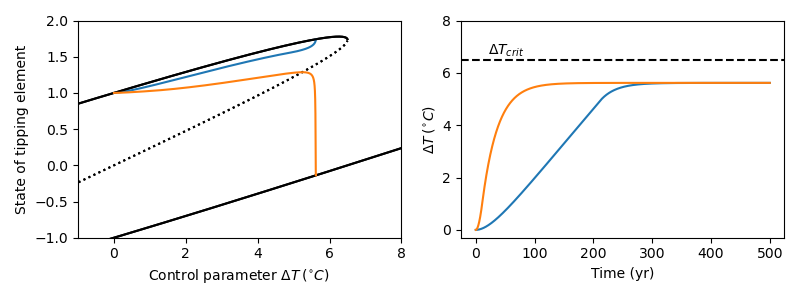

In [14]:
from numpy.polynomial import Polynomial as P

c=8.36*10**8
lam=-1
qcrit = 6.5
alpha=90
tau = 30

t0=0; tend=500 
dt=0.1
y0=[0,1]

cmax=[800,800]
r=np.array([0.5,10])*0.01
dec = [0,0]


fig, (ax3,ax2) = plt.subplots(1,2,figsize=(8,3))

for i in range (0,r.size):
    
    forcing = ramping1(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel_12(forcing,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
    
    ax1.plot(sol.t,forcing(sol.t)+dec[i],label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100))
    ax2.plot(sol.t,sol.y[0])
    
    ax4.plot(sol.t, sol.y[0]+alpha*(lam*sol.y[0]+ 5.35*np.log(forcing(sol.t)/280))*h/c)
#     ax4.plot(sol.y[0]+alpha*(lam*sol.y[0]+ 5.35*np.log(forcing(sol.t)/280))*h/c)
    
    N=1000
    DTex = np.linspace(-10,10,N)
    Z=np.empty((3,N))
    Z[:]=np.NaN

    for k in range (0,N) :
        
#         When using amocmodel_12
        DT=DTex[k]
        D=alpha/tau*(4/27)**0.5*DT/qcrit
        p=P([-D,1])
        p=-p**3+p-tau/alpha*D

        # When using amocmodel11
#         q = sol.y[0,k]+alpha*(lam*sol.y[0,k]+ 5.35*np.log(forcing(sol.t[k])/280))*h/c
#         p=P([0,1])
#         p=-p+p**3+(4/27)**0.5*q/qcrit

        rr = p.roots()
        R = rr.real[abs(rr.imag)<1e-5]
#         Z[0:R.size,k]= R
        Z[abs(rr.imag)<1e-5,k]= rr.real[abs(rr.imag)<1e-5]
        
#     ax3.plot(sol.t,Z[0,:],'k')
#     ax3.plot(sol.t,Z[1,:],'k:')
#     ax3.plot(sol.t,Z[2,:],'k')
#     ax3.plot(sol.t,sol.y[1])
    
    ax3.plot(DTex,Z[0,:],'k')
    ax3.plot(DTex,Z[1,:],'k:')
    ax3.plot(DTex,Z[2,:],'k')
    ax3.plot(sol.y[0],sol.y[1])


ax1.set_xlabel(r'Time (yr)')
ax1.set_ylabel(r'$CO_2$ (ppm)')
ax1.legend(fontsize=7,labelspacing=0.1)

ax2.set_xlabel(r'Time (yr)')
ax2.set_ylabel(r'$\Delta T\:(^{\circ}C)$')
ax2.axhline(6.5,0,1,color='k',ls='--')
ax2.set_ylim((-0.3,8))
ax2.annotate(r'$\Delta T_{crit}$', (20,6.7))

ax3.set_xlabel(r'Control parameter $\Delta T\:(^{\circ}C)$ ')
ax3.set_ylabel(r'State of tipping element')
ax3.set_xlim((-1,8))
ax3.set_ylim((-1,2))


ax4.set_xlabel(r'Time (yr)')
ax4.set_ylabel(r'$q\left(\Delta T(t),\dot{\Delta T}(t)\right)$')
ax4.axhline(qcrit,0,1,c='k',ls='--',lw=0.7)


plt.tight_layout()

#fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\youngminds2.svg",transparent=True)

<IPython.core.display.Javascript object>


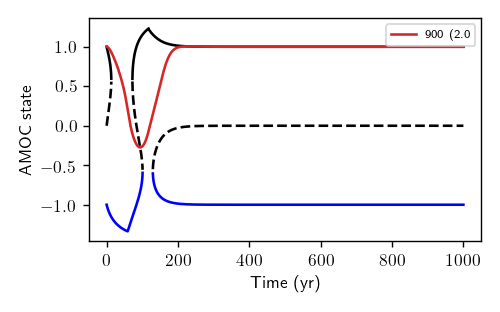

In [36]:
fig,ax=plt.subplots(1,1,figsize=(4,2.5))
ax.plot(sol.t,Z[0,:],'b')
ax.plot(sol.t,Z[1,:],'k--')
ax.plot(sol.t,Z[2,:],'k')
ax.plot(sol.t,sol.y[1],'C3',label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100))

ax.set_xlabel(r'Time (yr)')
ax.set_ylabel(r'AMOC state')
ax.legend(fontsize=7,labelspacing=0.1)


plt.tight_layout()

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\stockrtip2.pdf")

<IPython.core.display.Javascript object>


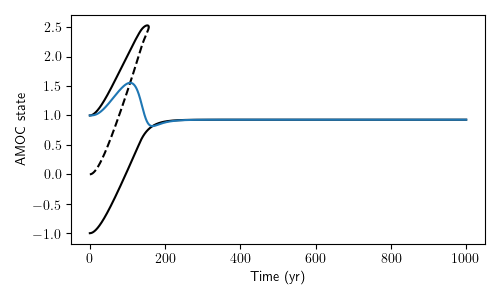

In [18]:
from numpy.polynomial import Polynomial as P

c=8.36*10**8
lam=-1
qcrit = 6.5
alpha=150
tau = 30

t0=0; tend=1000 
dt=0.1
y0=[0,1]

cmax=[1050]
r=np.array([1])*0.01



fig, (ax3) = plt.subplots(1,1,figsize=(5,3))

for i in range (0,r.size):
    
    forcing = ramping1(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel_12(forcing,c,lam,qcrit,alpha,tau,t0,tend,dt,y0)
    
    N=sol.y[0].size
    Z=np.empty((3,N))
    Z[:]=np.NaN

    for k in range (0,N) :

        DT=sol.y[0,k]
        D=alpha/tau*(4/27)**0.5*DT/qcrit
        p=P([-D,1])
        p=-p**3+p-tau/alpha*D

        r = p.roots()
        R = r.real[abs(r.imag)<1e-5]
        Z[0:R.size,k]= R 
        
    ax3.plot(sol.t,Z[0,:],'k')
    ax3.plot(sol.t,Z[1,:],'k--')
    ax3.plot(sol.t,Z[2,:],'k')
    ax3.plot(sol.t,sol.y[1])


ax3.set_xlabel(r'Time (yr)')
ax3.set_ylabel(r'AMOC state')

plt.tight_layout()


In [81]:
print(Z)

[[-1.00000000e+00 -9.99999463e-01 -9.99997856e-01 ...  8.55609280e-01
   8.55609281e-01  8.55609281e-01]
 [ 0.00000000e+00  7.15443899e-07  2.85811880e-06 ...  8.55609280e-01
   8.55609281e-01  8.55609281e-01]
 [ 1.00000000e+00  1.00000054e+00  1.00000214e+00 ...  8.55609280e-01
   8.55609281e-01  8.55609281e-01]]


## Model 1.3 : B-tipping + R-tipping 

# Models with two dimensions 

## Model 2.1 : Stratification and R-tipping

In [18]:
h=365*24*3600

def amocmodel_21(forcing,c,lam,qcrit,alpha,gamma,tau,t0,tend,dt,y0):
    
    n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)
    
    def f(t,y):
    
        F=forcing(t)
        z=float(np.log(F/280))
        
        dy = [0,0,0]
        
        dy[0] = (lam*y[0]+ 5.35*z)*h/c
        dy[1] = (y[1]-y[1]**3-(4/27)**0.5/qcrit*(g6*y[0]+gamma*(y[0]-y[2])))/tau
        dy[2] = -1/alpha*(y[2]-y[0])
        
        return dy
    
    #sol=solve_ivp(f, [t0,tend], y0,method= 'RK45',t_eval=teval,max_step=1)
    sol=solve_ivp(f, [t0,tend], y0,method= 'LSODA',t_eval=teval)
    
    return sol ;



<IPython.core.display.Javascript object>


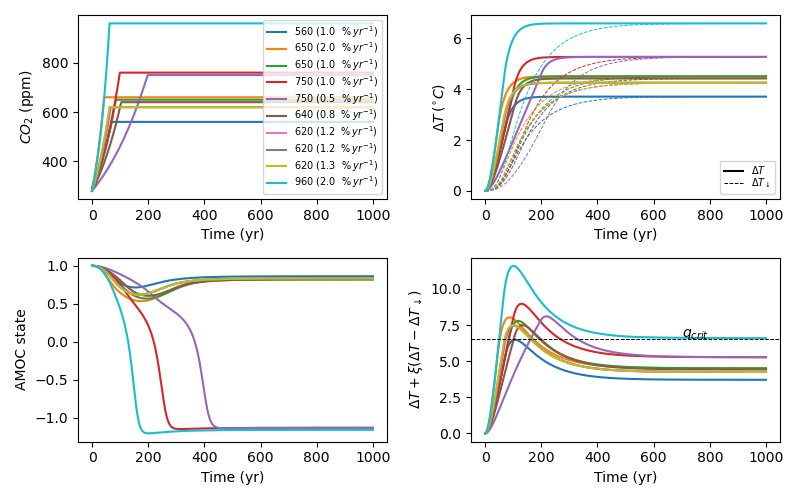

In [75]:
c=8.36*10**8
lam=-1
qcrit = 6.5
alpha=100
gamma =1.5
tau = 30
g6=1

t0=0; tend=1000 
dt=0.01
y0=[0,1,0]

cmax=[560,650,650,750,750,640,620,620,620,960]
r=np.array([1,2,1,1,0.5,0.8,1.2,1.25,1.3,2])*0.01
dec=[0,10,0,10,0,0,0,0,0,0]

fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=(8,5))
colors = ['C0', 'C1','C2','C3','C4','C5','C6','C7','C8','C9',]
for i in range (0,r.size):
    
    forcing = ramping1(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel_21(forcing,c,lam,qcrit,alpha,gamma,tau,t0,tend,dt,y0)
    
    ax1.plot(sol.t,forcing(sol.t)+dec[i],label=r'%d (%.1f  $\%%\:yr^{-1}$)'%(cmax[i],r[i]*100))
    ax2.plot(sol.t,sol.y[0],color=colors[i])
    ax2.plot(sol.t,sol.y[2],color=colors[i],linestyle='--',linewidth=0.7)
    ax3.plot(sol.t,sol.y[1])
    ax4.plot(sol.t, g6*sol.y[0]+gamma*(sol.y[0]-sol.y[2]))


ax1.set_xlabel(r'Time (yr)')
ax1.set_ylabel(r'$CO_2$ (ppm)')
ax1.legend(fontsize=7,labelspacing=0.1)

ax2.set_xlabel(r'Time (yr)')
ax2.set_ylabel(r'$\Delta T\:(^{\circ}C)$')
ax2.plot([],[],'k-', label= r'$\Delta T$')
ax2.plot([],[],'k--',lw=0.7, label= r'$\Delta T_{\downarrow}$')
ax2.legend(fontsize=7,labelspacing=0.1)

ax3.set_xlabel(r'Time (yr)')
ax3.set_ylabel(r'AMOC state')

ax4.set_xlabel(r'Time (yr)')
ax4.set_ylabel(r'$\Delta T+\xi(\Delta T - \Delta T_{\downarrow})$')
ax4.axhline(qcrit,0,1,c='k',ls='--',lw=0.7)
ax4.annotate(r'$q_{crit}$', (700,6.7))

plt.tight_layout()

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\stock2d1bis.pdf")


<IPython.core.display.Javascript object>


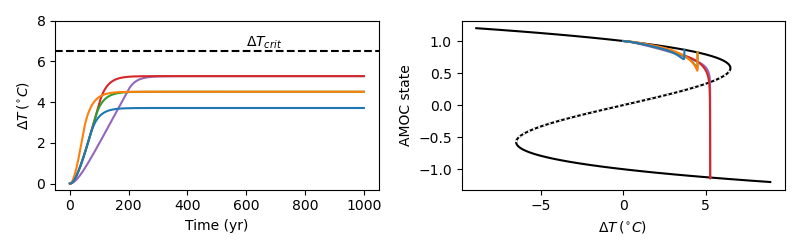

In [90]:



fig, (ax2,ax1) = plt.subplots(1,2,figsize=(8,2.5))

cmax=[560,650,650,750,750]
r=np.array([1,2,1,1,0.5])*0.01

v=np.linspace(-1.2,1.2,100)
vv = np.linspace(-1/3**0.5,1/3**0.5,60)

ax1.plot((v-v**3)*(27/4)**0.5*qcrit,v,'k',zorder=0)
ax1.plot((vv-vv**3)*(27/4)**0.5*qcrit,vv,'w:',zorder=0)

for i in range (0,5):
    
    forcing = ramping1(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel_21(forcing,c,lam,qcrit,alpha,gamma,tau,t0,tend,dt,y0)
    
    ax1.plot(sol.y[0],sol.y[1],label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100),zorder=r.size-i)
    ax2.plot(sol.t,sol.y[0],zorder=r.size-i)
    
    

# ax1.legend(fontsize=7,labelspacing=0.02,framealpha=1)
# ax1.set_ylim((0.25,1.15))
# ax1.set_xlim((-0.25,11))

ax2.axhline(6.5,0,1,color='k',ls='--')
ax2.set_ylim((-0.3,8))
ax2.annotate(r'$\Delta T_{crit}$', (600,6.7))
ax2.set_xlabel(r'Time (yr)')
ax2.set_ylabel(r'$\Delta T\:(^{\circ}C)$')


ax1.set_xlabel(r'$\Delta T\:(^{\circ}C)$ ')
ax1.set_ylabel(r'AMOC state')

plt.tight_layout()

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\youngminds3.svg",transparent=True)

In [91]:
fig.savefig(r"/home/vcouplet/Desktop/agtipesbdiag1.pdf")

<IPython.core.display.Javascript object>


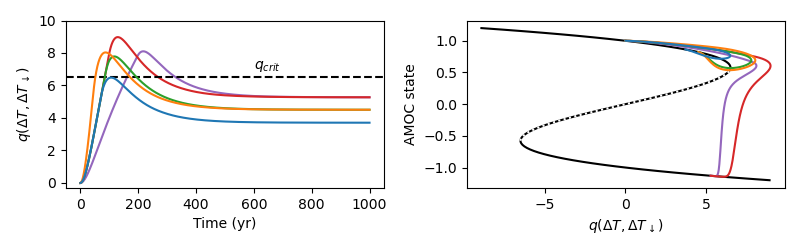

In [92]:
fig, (ax2,ax1) = plt.subplots(1,2,figsize=(8,2.5))

cmax=[560,650,650,750,750]
r=np.array([1,2,1,1,0.5])*0.01

v=np.linspace(-1.2,1.2,100)
vv = np.linspace(-1/3**0.5,1/3**0.5,60)

ax1.plot((v-v**3)*(27/4)**0.5*qcrit,v,'k',zorder=0)
ax1.plot((vv-vv**3)*(27/4)**0.5*qcrit,vv,'w:',zorder=0)

for i in range (0,5):
    
    forcing = ramping1(r[i],cmax[i],t0,tend,dt)
    sol = amocmodel_21(forcing,c,lam,qcrit,alpha,gamma,tau,t0,tend,dt,y0)
    
  #  ax1.plot(sol.y[0],sol.y[1],label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100),zorder=r.size-i)
  #  ax2.plot(sol.t,sol.y[0],zorder=r.size-i)
    
    ax1.plot(g6*sol.y[0]+gamma*(sol.y[0]-sol.y[2]),sol.y[1],label=r'%d (%.1f %% $\:yr^{-1}$)'%(cmax[i],r[i]*100),zorder=r.size-i)
    ax2.plot(sol.t,g6*sol.y[0]+gamma*(sol.y[0]-sol.y[2]),zorder=r.size-i)

# ax1.legend(fontsize=7,labelspacing=0.02,framealpha=1)
# ax1.set_ylim((0.25,1.15))
# ax1.set_xlim((-0.25,11))

ax2.axhline(6.5,0,1,color='k',ls='--')
ax2.set_ylim((-0.3,10))
ax2.annotate(r'$q_{crit}$', (600,7))
ax2.set_xlabel(r'Time (yr)')
ax2.set_ylabel(r'$q(\Delta T,\Delta T_{\downarrow})$')


ax1.set_xlabel(r'$q(\Delta T,\Delta T_{\downarrow})$')
ax1.set_ylabel(r'AMOC state')

plt.tight_layout()

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\youngminds3.svg",transparent=True)

In [93]:
fig.savefig(r"/home/vcouplet/Desktop/agtipesbdiag2.pdf")

In [73]:
c=8.36*10**8
qcrit = 6.5
alpha=15
gamma=10
tau = 30

y0=[0,1,0]
t0=0; tend=1500 
dt=0.01

N=10
lam = np.linspace(-1.86,-0.93,N)
r = np.linspace(0.2,2,N)*0.01

Ccrit = np.zeros((N,N))

for i in range(0,N) :
 
    for j in range(0,N) :
        
        c1=200
        c2=2300
        cmax=(c1+c2)/2
        
        forcing = ramping1(r[j],cmax,t0,tend,dt)
        sol = amocmodel_21(forcing,c,lam[i],qcrit,alpha,gamma,tau,t0,tend,dt,y0)
        b=sol.y[1][-1]
        
        for k in range(0,10) :
        
            if b>0 :
                c1=cmax
                cmax=(c1+c2)/2 
            else : 
                c2=cmax
                cmax=(c1+c2)/2
                
            forcing = ramping1(r[j],cmax,t0,tend,dt)
            sol = amocmodel_21(forcing,c,lam[i],qcrit,alpha,gamma,tau,t0,tend,dt,y0)
            b = sol.y[1][-1]
     
        Ccrit[i,j]=cmax
    

<IPython.core.display.Javascript object>


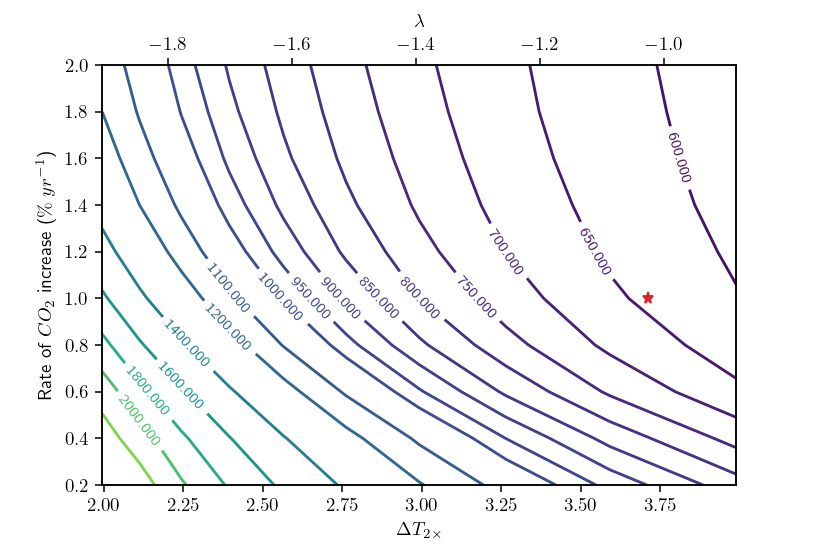

Text(0.5, 0, '$\\lambda$')

In [74]:
lam = np.linspace(-1.86,-0.93,N)
r = np.linspace(0.2,2,N)*0.01

L,R = np.meshgrid(lam,r)
fig, (ax1) = plt.subplots(1,1,figsize=(6,4))

lines = [600,650,700,750,800,850,900,950,1000,1100,1200,1400,1600,1800,2000,2200]

CS = ax1.contour(-3.71/lam,r*100,Ccrit.transpose(),lines,cmap='viridis',vmin=500,vmax=2600) 
ax1.clabel(CS, inline=2, fontsize=8)
ax1.plot(3.71,0.01*100,'C3*')
ax1.set_ylim((0.2,2))
ax1.set_ylabel(r'Rate of $CO_2$ increase ($\%\:yr^{-1}$)')
ax1.set_xlabel(r'$\Delta T_{2\times}$')

ax2 =ax1.twiny()
ax2.plot(lam,np.ones(lam.size)*2, color='None')
ax2.set_xlabel(r'$\lambda$')


In [63]:
%%time

c=8.36*10**8
lam=-1
qcrit = 6.5
alpha=150
gamma = 1
tau = 30

y0=[0,1,0]
t0=0; tend=2000 
dt=0.01

N=20

r = np.linspace(0.2,2,N)*0.01
cmax=np.linspace(400,1500,N)
tip = np.zeros((N,N))
maxy = np.zeros((N,N))
maxT = np.zeros((N,N))
ritchie = np.zeros((N,N))
BB= np.zeros((N,N))

M=lam*h/c 
db = 1/tau**2*8/3*(1/qcrit)

for i in range(0,N) :
    print(i)
    for j in range(0,N) :

        forcing = ramping1(r[i],cmax[j],t0,tend,dt)
        sol = amocmodel_21(forcing,c,lam,qcrit,alpha,gamma,tau,t0,tend,dt,y0)
        
        tip[i,j]=sol.y[1][-1]
        
        z = sol.y[0]+gamma*(sol.y[0]-sol.y[2])
        kt= np.argmax(z)
        maxy[i,j] = np.max(z)
        maxT[i,j] = np.max(sol.y[0])
        
        tmax=np.argmax(sol.y[0])
        DT=sol.y[0,tmax]
        roots, [x1,y1], [x2,y2] = amocmodel_21_stability(DT,c,lam,qcrit,alpha,gamma,tau,t0,10000,dt)
        Q=interpolate.interp1d(y2,x2,fill_value="extrapolate")
        BB[i,j] = sol.y[1,tmax]-Q(sol.y[2,tmax])
        
        
        if  maxy[i,j]> qcrit :
        
            
            ki = np.argmin(np.abs(z[:kt]-qcrit))
            ti = sol.t[ki]
            
            kf = np.argmin(np.abs(z[kt:]-qcrit))
            tf = sol.t[kt:][kf]
            
            R =  maxy[i,j]-qcrit
    
            ritchie[i,j] = db*R*(tf-ti)**2


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 2min 29s, sys: 1.48 s, total: 2min 30s
Wall time: 37.9 s


In [29]:
print(BB)

[[ 8.14954596e-01  7.71177929e-01  7.22174981e-01  6.79253667e-01
   6.31789869e-01  6.04034571e-01  5.59991298e-01  5.19257854e-01
   4.76488646e-01  3.94510919e-01  3.55407352e-01  3.01052767e-01
   2.81312045e-01 -1.61186091e+00 -1.66359194e+00 -3.33332726e+09
  -2.22567039e+11 -4.96072567e+11 -5.49666166e+11 -7.66671194e+11]
 [ 8.14367670e-01  7.68832295e-01  7.17456462e-01  6.79769569e-01
   6.31137972e-01  6.03979588e-01  5.62753797e-01  5.15719049e-01
   4.01798405e-01  3.72812798e-01  3.20290216e-01 -1.53752154e+00
  -1.57829803e+00 -1.62335840e+00 -1.67719914e+00 -6.05889449e+09
  -2.22488483e+11 -1.56721826e+12 -5.08520224e+12 -2.16022007e+12]
 [ 8.23015423e-01  7.67722016e-01  7.17555147e-01  6.83419935e-01
   6.46442634e-01  6.05027817e-01  5.62709991e-01 -1.65968767e+02
   3.80437113e-01  3.27713144e-01 -1.50803100e+00 -1.54692121e+00
  -1.58688484e+00 -1.63284722e+00 -1.69384597e+00 -1.40511883e+10
  -6.82188279e+11 -6.21821420e+11 -3.66511788e+11 -1.55070018e+12]
 [ 8.12

<IPython.core.display.Javascript object>


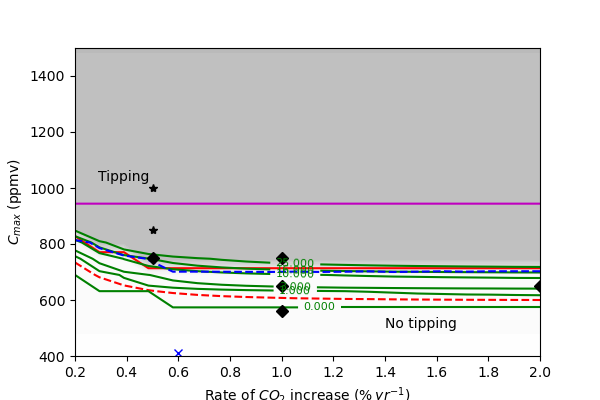

In [64]:
from scipy.ndimage.filters import gaussian_filter
data = gaussian_filter(ritchie, 0.5)

fig, (ax1) = plt.subplots(1,1,figsize=(6,4))

cs=ax1.contourf(r*100,cmax,-tip.transpose(),20,cmap='Greys',vmax=5) 
# fig.colorbar(cs,ax=ax1)
cs2 =ax1.contour(r*100,cmax,maxy.transpose()-qcrit,0,colors='r',linestyles='--')
cs3 =ax1.contour(r*100,cmax,-tip.transpose(),0,colors='r',linestyles='-')
# cs4 =ax1.contour(r*100,cmax,data.transpose(),[0,1,3,10,16,25],colors='g',linestyles='-')
cs4 =ax1.contour(r*100,cmax,ritchie.transpose(),[0,1,3,10,16,25],colors='g',linestyles='-')
ax1.clabel(cs4, inline=1, fontsize=8)

cs6 =ax1.contour(r*100,cmax,maxT.transpose(),[qcrit],colors='m',linestyles='-')
cs5 =ax1.contour(r*100,cmax,BB.transpose(),[0],colors='b',linestyles='--')
# ax1.plot(r*100,np.ones(r.size)*280*np.exp(-lam*qcrit/5.35),c='r',ls='--')
ax1.plot(np.array([1,2,1,1,0.5]),[560,650,650,750,750],'kD')
ax1.plot(np.array([0.5,0.5]),[850,1000],'k*')
ax1.set_xlabel(r'Rate of $CO_2$ increase ($\%\:yr^{-1}$)')
ax1.set_ylabel(r'$C_{max}$ (ppmv)')
ax1.plot([0.6],[410],'bx')

# ax1.annotate(r'B-tipping if $\xi=0$', (0.8,1000))
# ax1.annotate(r'R-tipping \\ (no tipping if $\xi=0$)', (1.3,800))
ax1.annotate(r'No tipping', (1.4,500))
ax1.annotate(r'Tipping', (0.29,1025))

plt.show()

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\stock2d5.pdf")

In [96]:
c=8.36*10**8
lam=-1
qcrit = 6.5
alpha=10
tau = 10
gamma=10

y0=[0,1,0]
t0=0; tend=2000 
dt=0.01

N=100
# lam = np.linspace(-1.86,-0.93,N)
r = np.linspace(0.2,3,N)*0.01
cmax=690
tip = np.zeros(N)
maxy = np.zeros(N)
ritchie = np.zeros(N)

M=lam*h/c 
db = 1/tau**2*8/3*(1/qcrit)

for i in range(0,N) :

    forcing = ramping1(r[i],cmax,t0,tend,dt)
    sol = amocmodel_21(forcing,c,lam,qcrit,alpha,gamma,tau,t0,tend,dt,y0)

    tip[i]=sol.y[1][-1]
    t1= np.log(cmax/280)/np.log(1+r[i])
    maxy[i] = np.max(sol.y[0]+gamma*(sol.y[0]-sol.y[2]))

    if  maxy[i]> qcrit :

        z = sol.y[0]+gamma*(sol.y[0]-sol.y[2])
        ki = np.argmin(np.abs(z[sol.t<t1]-qcrit))
        ti = sol.t[ki]

        kf = np.argmin(np.abs(z[sol.t>t1]-qcrit))
        tf = sol.t[sol.t>t1][kf]

        R =  maxy[i]-qcrit

        ritchie[i] = db*R*(tf-ti)**2


<IPython.core.display.Javascript object>


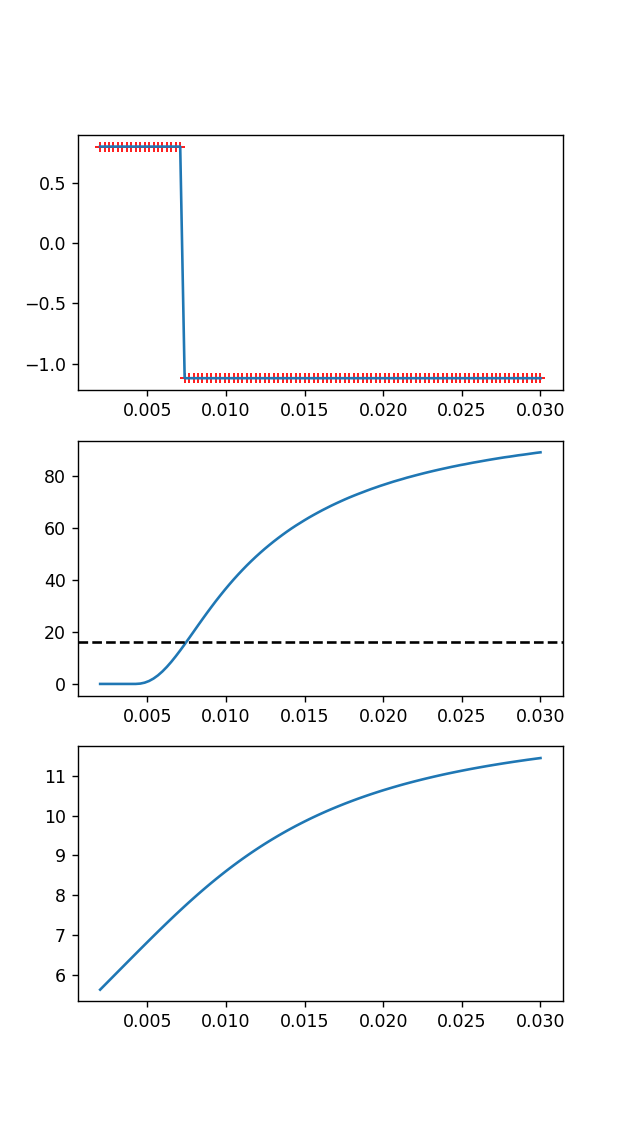

In [46]:
fig, (ax1,ax2,ax3)=plt.subplots(3,1,figsize=(5,9))

ax1.plot(r,tip,'r+')
ax1.plot(r,tip,'C0')
ax2.plot(r,ritchie)
ax2.axhline(16,0,1,c='k',ls='--')
ax3.plot(r,maxy)

plt.show()

### Visualisations and animations of phase space

We start with just a simple but awesome representation of the flow 

<IPython.core.display.Javascript object>


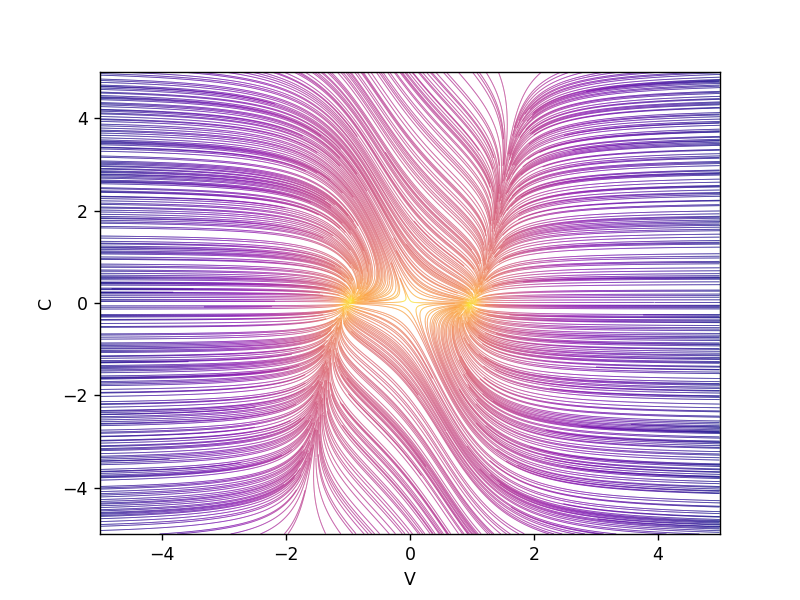

(-5, 5)

In [48]:
v=np.linspace(-5,5,100)
c=np.linspace(-5,5,100)
V,C = np.meshgrid(v,c)

N=1000

x=0
dV = (V-V**3-(4/27)**0.5/qcrit*(x+gamma*(x-C)))/tau
dC = -1/alpha*(C-x)

px = np.concatenate([np.ones(v[::5].size)*-5,np.ones(v[::5].size)*5,v[20:80:5],v[20:80:5]])
py = np.concatenate([v[::5],v[::5],np.ones(v[20:80:5].size)*-5,np.ones(v[20:80:5].size)*5])

points = (np.random.rand(N,2)-1/2)*10

fig,ax=plt.subplots()

ax.streamplot(v,c,dV,dC,35 , start_points = points, color=-np.log((dV**2+dC**2)**0.5), cmap='plasma',linewidth=0.5,arrowsize=0)

ax.set_xlabel('V')
ax.set_ylabel('C')
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))


Function that returns the fixed points (stables and unstable ones) as well as the basin boundary

In [21]:
h=365*24*3600

def amocmodel_21_stability(DT,c,lam,qcrit,alpha,gamma,tau,t0,tend,dt):
    
    n = int((tend-t0)/dt)+1 ; teval=np.linspace(t0,tend,n)
    
    roots = np.sort(np.real(np.roots([-1,0,1,-(4/27)**0.5/qcrit*DT])))
    
    def f(t,y):
    
        dy = [0,0]

        dy[0] = (y[0]-y[0]**3-(4/27)**0.5/qcrit*(DT+gamma*(DT-y[1])))/tau*-1
        dy[1] = -1/alpha*(y[1]-DT)*-1
        
        return dy
    
    y0_1 = [roots[1]+10**-8,DT+10**-8]
    y0_2 = [roots[1]-10**-8,DT-10**-8]
    
    sol1=solve_ivp(f, [t0,tend], y0_1,method= 'RK45',t_eval=teval)
    sol2=solve_ivp(f, [t0,tend], y0_2,method= 'RK45',t_eval=teval)
    
    return roots, [sol1.y[0],sol1.y[1]], [sol2.y[0],sol2.y[1]] ;


Trajectory in phase space with initial and final stability situations (basin boundaries and fixed points)

<IPython.core.display.Javascript object>


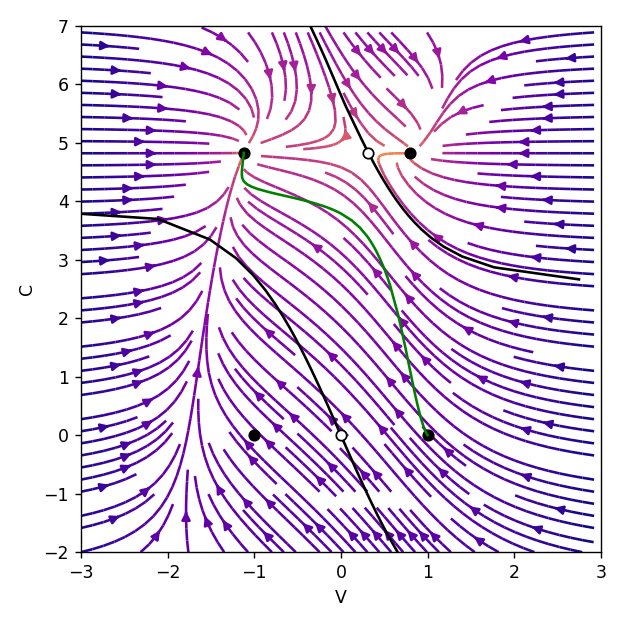

In [19]:
c=8.36*10**8
lam=-1
qcrit = 6.5
alpha=10
gamma=10
tau = 10


y0=[0,1,0]
t0=0; tend=300
dt=1
cmax=690
r=0.0109

forcing = ramping1(r,cmax,t0,tend,dt)
sol = amocmodel_21(forcing,c,lam,qcrit,alpha,gamma,tau,t0,tend,dt,y0)

DT=0
roots, [x1,y1], [x2,y2] = amocmodel_21_stability(DT,c,lam,qcrit,alpha,gamma,tau,t0,1000,dt)

DT2=sol.y[0][-1]
roots2, [x11,y11], [x22,y22] = amocmodel_21_stability(DT2,c,lam,qcrit,alpha,gamma,tau,t0,1000,dt)

v=np.linspace(-3,3,100)
c=np.linspace(-2,7,100)
V,C = np.meshgrid(v,c)

DT3=sol.y[0,-1]
dV = (V-V**3-(4/27)**0.5/qcrit*(DT3+gamma*(DT3-C)))/tau
dC = -1/alpha*(C-DT3)

fig, (ax) = plt.subplots(1,1,figsize=(5,5))

ax.streamplot(v,c,dV,dC,1.5 ,color=-np.log((dV**2+dC**2)**0.5), cmap='plasma')
ax.set_xlabel('V')
ax.set_ylabel('C')

ax.plot(x1,y1,'k-')
ax.plot(x2,y2,'k-')
ax.plot(roots[[0,2]],[DT,DT],'ko')
ax.plot(roots[1],DT,'ko',markerfacecolor='w')

ax.plot(x11,y11,'k-')
ax.plot(x22,y22,'k-')
ax.plot(roots2[[0,2]],[DT2,DT2],'ko')
ax.plot(roots2[1],DT2,'ko',markerfacecolor='w')

ax.plot(sol.y[1],sol.y[2],'g')

ax.set_xlim((-3,3))
ax.set_ylim((-2,7))

plt.tight_layout()

<IPython.core.display.Javascript object>


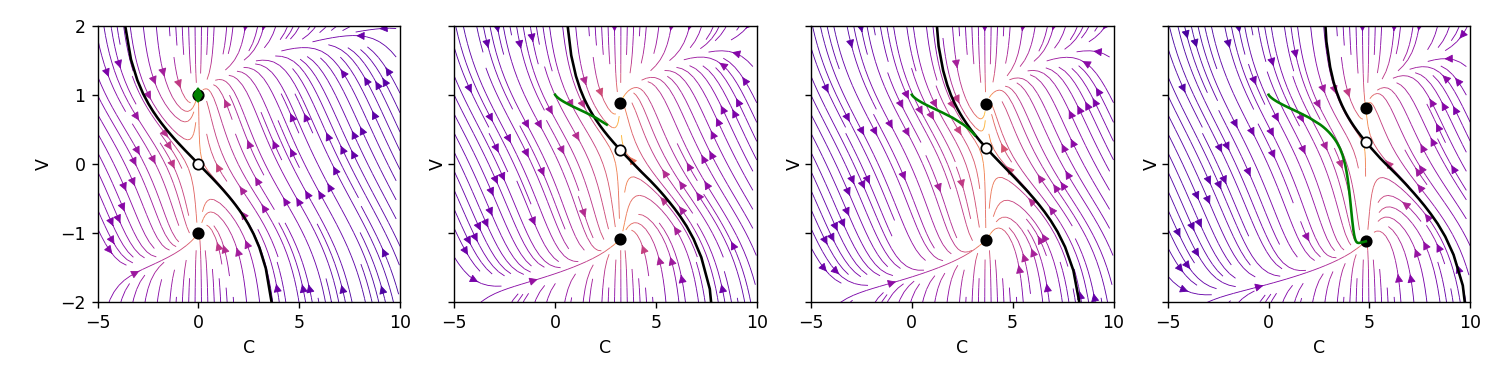

C:\Users\vicco\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


In [59]:
c=8.36*10**8
lam=-1
qcrit = 6.5
alpha=10
gamma=10
tau = 10


y0=[0,1,0]
t0=0; tend=300
dt=1
cmax=690
r=0.0109

forcing = ramping1(r,cmax,t0,tend,dt)
sol = amocmodel_21(forcing,c,lam,qcrit,alpha,gamma,tau,t0,tend,dt,y0)

DT=0
roots, [x1,y1], [x2,y2] = amocmodel_21_stability(DT,c,lam,qcrit,alpha,gamma,tau,t0,1000,dt)

DT2=sol.y[0][-1]
roots2, [x11,y11], [x22,y22] = amocmodel_21_stability(DT2,c,lam,qcrit,alpha,gamma,tau,t0,1000,dt)

v=np.linspace(-3,3,100)
c=np.linspace(-5,10,100)
C,V = np.meshgrid(c,v)

DT3=sol.y[0,-1]
DT3=0
dV = (V-V**3-(4/27)**0.5/qcrit*(DT3+gamma*(DT3-C)))/tau
dC = -1/alpha*(C-DT3)

fig, (ax,ax2,ax4,ax3) = plt.subplots(1,4,figsize=(12,3),sharey= True)

ax.streamplot(c,v,dC,dV,1.5 ,color=-np.log((dV**2+dC**2)**0.5), cmap='plasma',linewidth=0.5)
ax.set_xlabel('C')
ax.set_ylabel('V')

ax.plot(y1,x1,'k-')
ax.plot(y2,x2,'k-')
ax.plot([DT,DT],roots[[0,2]],'ko')
ax.plot(DT,roots[1],'ko',markerfacecolor='w')

ax.plot(sol.y[2,0],sol.y[1,0],'gd')

t2=34
DT3=sol.y[0,t2]
dV = (V-V**3-(4/27)**0.5/qcrit*(DT3+gamma*(DT3-C)))/tau
dC = -1/alpha*(C-DT3)

roots2, [x11,y11], [x22,y22] = amocmodel_21_stability(DT3,c,lam,qcrit,alpha,gamma,tau,t0,1000,dt)

ax2.streamplot(c,v,dC,dV,1.5 ,color=-np.log((dV**2+dC**2)**0.5), cmap='plasma',linewidth=0.5)
ax2.set_xlabel('C')
ax2.set_ylabel('V')

ax2.plot(y11,x11,'k-')
ax2.plot(y22,x22,'k-')
ax2.plot([DT3,DT3],roots2[[0,2]],'ko')
ax2.plot(DT3,roots2[1],'ko',markerfacecolor='w')

ax2.plot(sol.y[2,:t2],sol.y[1,:t2],'g')


t2=38
DT3=sol.y[0,t2]
dV = (V-V**3-(4/27)**0.5/qcrit*(DT3+gamma*(DT3-C)))/tau
dC = -1/alpha*(C-DT3)

roots2, [x11,y11], [x22,y22] = amocmodel_21_stability(DT3,c,lam,qcrit,alpha,gamma,tau,t0,1000,dt)

ax4.streamplot(c,v,dC,dV,1.5 ,color=-np.log((dV**2+dC**2)**0.5), cmap='plasma',linewidth=0.5)
ax4.set_xlabel('C')
ax4.set_ylabel('V')

ax4.plot(y11,x11,'k-')
ax4.plot(y22,x22,'k-')
ax4.plot([DT3,DT3],roots2[[0,2]],'ko')
ax4.plot(DT3,roots2[1],'ko',markerfacecolor='w')

ax4.plot(sol.y[2,:t2],sol.y[1,:t2],'g')




DT3=sol.y[0,-1]
dV = (V-V**3-(4/27)**0.5/qcrit*(DT3+gamma*(DT3-C)))/tau
dC = -1/alpha*(C-DT3)

roots2, [x11,y11], [x22,y22] = amocmodel_21_stability(DT3,c,lam,qcrit,alpha,gamma,tau,t0,1000,dt)

ax3.streamplot(c,v,dC,dV,1.5 ,color=-np.log((dV**2+dC**2)**0.5), cmap='plasma',linewidth=0.5)
ax3.set_xlabel('C')
ax3.set_ylabel('V')

ax3.plot(y11,x11,'k-')
ax3.plot(y22,x22,'k-')
ax3.plot([DT2,DT2],roots2[[0,2]],'ko')
ax3.plot(DT2,roots2[1],'ko',markerfacecolor='w')

ax3.plot(sol.y[2,:-1],sol.y[1,:-1],'g')

ax.set_ylim((-2,2))
ax.set_xlim((-5,10))

ax2.set_ylim((-2,2))
ax2.set_xlim((-5,10))

ax3.set_ylim((-2,2))
ax3.set_xlim((-5,10))

ax4.set_ylim((-2,2))
ax4.set_xlim((-5,10))

plt.tight_layout()

<IPython.core.display.Javascript object>


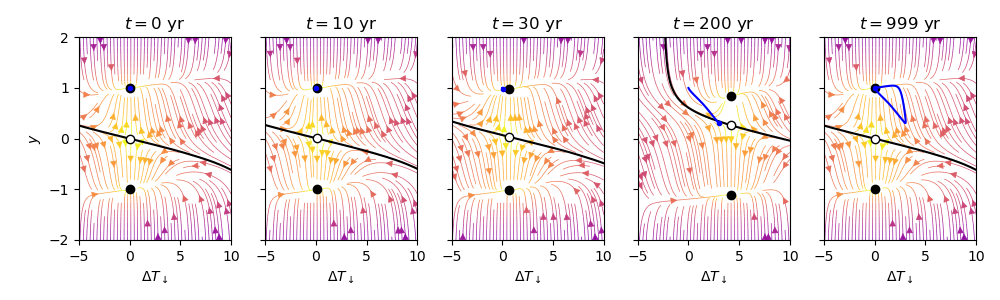

0.0


<ipython-input-51-7bd4cc9cde0e>:38: RuntimeWarning: divide by zero encountered in log
  ax.streamplot(c,v,dC,dV,1.5 ,color=-np.log((dV**2+dC**2)**0.5),cmap='plasma',norm=norm,linewidth=0.5)


0.08890395030567085
0.6409649714663082
4.174143322253828
4.577619309897348e-09
146


In [51]:
c=8.36*10**8
lam=-1
qcrit = 6.5
alpha=150
gamma=1
tau = 30


y0=[0,1,0]
t0=0; tend=1000
dt=1
cmax=1000
r=0.01

forcing = ramping2(r,cmax,t0,tend,dt)
sol = amocmodel_21(forcing,c,lam,qcrit,alpha,gamma,tau,t0,tend,dt,y0)
tmax=np.argmax(sol.y[0])

timestamps = [0,tmax-50,tmax,tmax+50,sol.t.size-1]
timestamps = [0,10,30,200,1000-1]

v=np.linspace(-3,3,100)
c=np.linspace(-5,10,100)
C,V = np.meshgrid(c,v)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 3),
                        sharey= True)

for ax, t in zip(axs.flat, timestamps):
    
    DT=sol.y[0,t] 
    print(DT)
    roots, [x1,y1], [x2,y2] = amocmodel_21_stability(DT,c,lam,qcrit,alpha,gamma,tau,t0,10000,dt)
    dV = (V-V**3-(4/27)**0.5/qcrit*(DT+gamma*(DT-C)))/tau
    dC = -1/alpha*(C-DT)

    norm = plt.Normalize(vmin = 0, vmax=5.2)      
    ax.streamplot(c,v,dC,dV,1.5 ,color=-np.log((dV**2+dC**2)**0.5),cmap='plasma',norm=norm,linewidth=0.5)
    ax.set_xlabel(r'$\Delta T_{\downarrow}$')
    ax.set_ylabel(r'$y$')
    
    if DT<=qcrit :
        ax.plot(y1,x1,'k-')
        ax.plot(y2,x2,'k-')
        ax.plot([DT,DT],roots[[0,2]],'ko')
        ax.plot(DT,roots[1],'ko',markerfacecolor='w')
       
    else :
        ax.plot(DT,roots[0],'ko')
        
    ax.plot(sol.y[2,t],sol.y[1,t],'b.') 
    ax.plot(sol.y[2,:t+1],sol.y[1,:t+1],'b')       
    ax.set_ylim((-2,2))
    ax.set_xlim((-5,10))
    ax.set_title(r'$t = %.0f$ yr'%sol.t[t])
    ax.label_outer() 
    
# for ax in axs:
#     ax.label_outer()    
    
plt.tight_layout()
plt.show()
print(tmax)

# fig.savefig(r"C:\Users\vicco\Documents\THESE\figures\stock2d9.pdf")

**Animation**

<IPython.core.display.Javascript object>


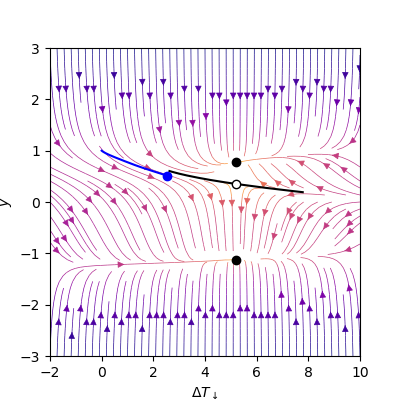

In [26]:
c=8.36*10**8
lam=-1
qcrit = 6.5
alpha=150
gamma=1
tau = 30

y0=[0,1,0]
t0=0; tend=300
dt=1
cmax=750
r=0.01

forcing = ramping1(r,cmax,t0,tend,dt)
sol = amocmodel_21(forcing,c,lam,qcrit,alpha,gamma,tau,t0,tend,dt,y0)

DT=0
roots, [x1,y1], [x2,y2] = amocmodel_21_stability(DT,c,lam,qcrit,alpha,gamma,tau,t0,tend,dt)

v=np.linspace(-3,3,100)
c=np.linspace(-2,10,100)
C,V = np.meshgrid(c,v)

dV = (V-V**3-(4/27)**0.5/qcrit*(DT+gamma*(DT-C)))/tau
dC = -1/alpha*(C-DT)

fig, (ax) = plt.subplots(1,1,figsize=(4,4))

ax.streamplot(c,v,dC,dV,1.5 ,color=-np.log((dV**2+dC**2)**0.5), cmap='plasma',linewidth=0.5)
ax.set_xlabel(r'$\Delta T_{\downarrow}$')
ax.set_ylabel(r'$y$')

ax.plot(y1,x1,'k-')
ax.plot(y2,x2,'k-')
ax.plot([DT,DT],roots[[0,2]],'ko')
ax.plot(DT,roots[1],'ko',markerfacecolor='w')

ax.set_ylim((-3,3))
ax.set_xlim((-2,10))

def animate(i):
    ax.collections = [] # clear lines streamplot
    ax.patches = [] # clear arrowheads streamplot
    ax.lines = []
    DT=sol.y[0][i]
    dV = (V-V**3-(4/27)**0.5/qcrit*(DT+gamma*(DT-C)))/tau
    dC = -1/alpha*(C-DT)
    
    roots, [x1,y1], [x2,y2] = amocmodel_21_stability(DT,c,lam,qcrit,alpha,gamma,tau,t0,10*tend,dt)
   
    if DT<=qcrit:
        
        g1 = ax.plot(y1,x1,'k-')
        g2 =ax.plot(y2,x2,'k-')
        g3 = ax.plot([DT,DT],roots[[0,2]],'ko')
        g4 = ax.plot(DT,roots[1],'ko',markerfacecolor='w')
    else : 
        g1 = ax.plot([],[])
        g2 =ax.plot([],[])
        g3 = ax.plot([DT],roots[[0]],'ko')
        g4 = ax.plot([],[])
    
    g5 = ax.plot(sol.y[2][i],sol.y[1][i],'bo')
    g6 = ax.plot(sol.y[2][:i],sol.y[1][:i],'b-')
    
    stream=ax.streamplot(c,v,dC,dV,1.5 ,color=-np.log((dV**2+dC**2)**0.5), cmap='plasma',linewidth=0.5)

    return stream,g1,g2,g3,g4,g5,g6

anim = FuncAnimation(fig, animate, frames=sol.t.size, interval=1, blit=False,repeat=False)
FFMpegWriter = animation.writers['ffmpeg']
# Change the video bitrate as you like and add some metadata.
mywriter = FFMpegWriter(fps=15, bitrate=2000)

anim.save("newanim2.mp4", writer=mywriter)


## Model D-O : AMOC tipping and D-O events

We try to acomodate de D-O events in our framework